# Statistics

# import functions

In [62]:
from sqlays import export_sql, import_sql
from matheq import Cel_to_Kel, Kel_to_Cel, to_pot_temp
from mapscre import station_map, bathy_data, contour_ver, TS_diagram
from iscays import sum_up, isc_summary, depth_bin_interval, particle_bin_interval, isc_xlsx, read_isc
from ctdays import find_start_row, raw_ctd_to_df
from graphcre import deployment_constancy, vertical_each_org_distribution, stacked_vertical_distribution, comp_vertical_distribution
from matheq import calDist
from timeinfo import day_night
from matplotlib import pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np
import scipy.stats as stats
import os, glob, datetime, gsw, cmocean, math
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



# import data

In [78]:
file_path = os.path.expanduser('~/Git/OCEANpy/data')
loki_df = export_sql('loki', 'all', 'awi_server')
ctd_df = export_sql('ctd', 'ctd_meta', 'local')
isc_stb = export_sql('isc', 'isc_meta', 'local')
isc_file_list = glob.glob(file_path+os.sep+'isc'+os.sep+'*.xlsx')
isc_each_stb = isc_stb[isc_stb['cruise_station_haul'].str.contains('PS107') & isc_stb['profile_number'].notnull()]

# data pre-processing

In [73]:
# data processing for LOKI data
wm_dict = {'PS107_010-5': (70, 95), 'PS107_012-4': (70, 155), 'PS107_014-5': (50, 215), 'PS107_016-4': (100, 270)}
loki_stations = ('PS107_010-5', 'PS107_012-4', 'PS107_014-5', 'PS107_016-4')
loki_df_sel = loki_df.loc[loki_df['station'].str.contains('|'.join(loki_stations))]
print(list(loki_df_sel))
sp_col = ['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus', 'Heterorhabdus', 'Metridia', 'Microcalanus',
          'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto']


sf_df = pd.DataFrame() # surface water mass df
aw_df = pd.DataFrame() # atlantic water mass df
adw_df = pd.DataFrame() # atlantic dense water mass df

for s in loki_stations:
    
    # count the sp with 5m depth bin
    each_st_df = loki_df_sel.loc[loki_df_sel['station'] == s]
    each_st_bin_df = pd.DataFrame(columns=sp_col)
    row = 0
    for d in range(0, math.ceil(max(each_st_df['loki_depth'])), 5):
        bin_df = each_st_df.loc[(each_st_df['loki_depth'] >= d) & (each_st_df['loki_depth'] < d+5)]
        for c in sp_col:
            if c == 'Chaetognatha' or c == 'Rhizaria': # check onlyin col = phylum
                count = bin_df['phylum'].loc[bin_df['phylum']==c].count()
                each_st_bin_df.loc[row, c] = count

            elif c == 'Ostracoda': # check onlyin col = class
                count = bin_df['class'].loc[bin_df['class']==c].count()
                each_st_bin_df.loc[row, c] = count
                
            else: # check onlyin col = genus
                count = bin_df['genus'].loc[bin_df['genus']==c].count()
                each_st_bin_df.loc[row, c] = count
        each_st_bin_df.loc[row, 'depth'] = d+2.5
        row += 1
        
    
    # move data to following water mass
    up, down = wm_dict[s]
    sf_df = sf_df.append(each_st_bin_df.loc[(each_st_bin_df['depth']>=0) & (each_st_bin_df['depth']<up)])
    aw_df = aw_df.append(each_st_bin_df.loc[(each_st_bin_df['depth']>=up) & (each_st_bin_df['depth']<down)])
    adw_df = adw_df.append(each_st_bin_df.loc[each_st_bin_df['depth']>=down])
    
sf_df.reset_index(drop=True, inplace = True)
aw_df.reset_index(drop=True, inplace = True)
adw_df.reset_index(drop=True, inplace = True)

sf_df['tag'] = 'surface'
aw_df['tag'] = 'atlantic'
adw_df['tag'] = 'atlantic_dense'

all_df = pd.concat([sf_df, aw_df, adw_df], ignore_index=True)

['vessel', 'cruise', 'station', 'region', 'latitude', 'longitude', 'bottom_depth', 'date_time', 'loki_depth', 'temperatue', 'salinity', 'oxygen', 'fluorescence', 'manual_classification', 'developmental_stage', 'area_pixel', 'area_sqrmm', 'spec_length', 'spec_width', 'image_filename', 'animal', 'copepod', 'phylum', 'class', 'spec_order', 'family', 'genus', 'species']


In [81]:
# data processing for Particle data
isc_stations = ('PS107_10_3', 'PS107_12_2', 'PS107_14_7', 'PS107_16_2')
isc_sel_stb = isc_stb.loc[isc_stb['cruise_station_haul'].str.contains('|'.join(isc_stations))]


isc_all_df = pd.DataFrame(columns=['cruise_station_cast','lat', 'lon', 'depth', 'temp', 'sal','turb', 'fluo', 'ctd_total_vol', 'ctd_total_abd', 'med_ESD', 'avg_ESD', 'vol_150-500', 'vol_500-1000', 'vol_total', 'abd_150-500', 'abd_500-1000', 'abd_total' ])
for index, value in isc_sel_stb.iterrows():
    # select one station from one isc station and get cruise name, station number and profilenumber of ISC
    cruise, station, cast, profile_num = value['cruise_station_haul'].split('_')[0], int(float(value['cruise_station_haul'].split('_')[1])), str(value['cruise_station_haul'].split('_')[2]),int(float(value['profile_number']))
    # Based on the cruise and profilenumber of ISC import data from excel file
    isc_excel = str('IR'+str(profile_num).zfill(2)+'_DownCast_'+cruise+'.xlsx')
    for i in isc_file_list:
        if i.split(os.sep)[-1] == isc_excel:
            lat, lon = value['lat'], value['lon']
            particle_range = [150, 500, 1000, 100000] # micro meter
            # from here specific station.
            isc_ctd_df, vol_spec_df, aggr_con_df, size_spec_df = isc_xlsx(i, 10, particle_range, 'processed')
            df = pd.DataFrame(columns=['lat', 'lon', 'depth', 'temp', 'sal', 'turb', 'fluo', 'ctd_total_vol', 'ctd_total_abd', 'med_ESD', 'avg_ESD', 'vol_150-500', 'vol_500-1000', 'vol_total', 'abd_150-500', 'abd_500-1000', 'abd_total' ])
            df['depth'], df['sal'], df['temp']  = isc_ctd_df['Depths (m)'], isc_ctd_df['Salinity (PSU)'], isc_ctd_df['Temperature (dC)']
            df['turb'], df['fluo'] = isc_ctd_df['Turbidity (NTU)'], isc_ctd_df['Fluorescence (mg/m3)']
            df['ctd_total_vol'], df['ctd_total_abd'] = isc_ctd_df['Total Aggregate Volume (ppm)'], isc_ctd_df['Aggregate abundance (#/l)']
            df['med_ESD'], df['avg_ESD'] = isc_ctd_df['Median ESD (µm)'], isc_ctd_df['Average ESD (µm)']
            df['vol_150-500'], df['vol_500-1000'], df['vol_total'] = vol_spec_df['150-500'], vol_spec_df['500-1000'], vol_spec_df['total']
            df['abd_150-500'], df['abd_500-1000'], df['abd_total'] = aggr_con_df['150-500'], aggr_con_df['500-1000'], aggr_con_df['total']
            df['lat'], df['lon'] = lat, lon
            df['cruise_station_cast'] = str(cruise) +'_'+ str(station) +'_'+ str(cast)
            
            isc_all_df = isc_all_df.append(df, ignore_index=True)

isc_all_df = isc_all_df.dropna()

In [82]:
print(isc_all_df)

    cruise_station_cast      lat      lon depth      temp        sal  \
0            PS107_10_3  78.9769   2.4908    10  4.352576  23.965060   
1            PS107_10_3  78.9769   2.4908    20  2.326581  32.062130   
2            PS107_10_3  78.9769   2.4908    30  4.584564  34.448854   
3            PS107_10_3  78.9769   2.4908    40  5.223962  34.663872   
4            PS107_10_3  78.9769   2.4908    50  4.737914  34.823360   
..                  ...      ...      ...   ...       ...        ...   
161          PS107_16_2  79.0023  2.26516   340  2.701866  34.996499   
162          PS107_16_2  79.0023  2.26516   350  2.451483  34.972098   
163          PS107_16_2  79.0023  2.26516   360  2.310153  34.960913   
164          PS107_16_2  79.0023  2.26516   370  2.144588  34.947994   
165          PS107_16_2  79.0023  2.26516   380  2.089433  34.945503   

         turb      fluo  ctd_total_vol  ctd_total_abd     med_ESD     avg_ESD  \
0    0.272179  0.070150       0.358555     178.765341 

# Linear Discriminant analysis

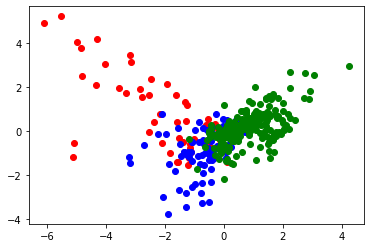

In [72]:
# normalise data
all_df_scaled = StandardScaler().fit_transform(all_df[['Chaetognatha', 'Rhizaria', 'Ostracoda', 'Calanus', 'Heterorhabdus', 'Metridia', 'Microcalanus',
          'Oithona', 'Oncaea', 'Paraeuchaeta', 'Pseudocalanus', 'Themisto']])


lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(all_df_scaled, all_df['tag'])
df_lda = lda.transform(all_df_scaled)
df_lda_component = pd.DataFrame(df_lda,columns=['x', 'y'])
df_lda_component['target'] = all_df['tag']

plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='surface'], df_lda_component['y'].loc[df_lda_component['target']=='surface'], c='red')
plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic'], c='blue')
plt.scatter(df_lda_component['x'].loc[df_lda_component['target']=='atlantic_dense'], df_lda_component['y'].loc[df_lda_component['target']=='atlantic_dense'], c='green')

plt.show()
plt.close()